# Preprocess WAVs into mel-frequency cepstrum (MFC) JPEGs
This script is used to convert audio files of the wav format into MFC images. The resulting images are used to train a CNN to recognise the speaker's gender. Credits: Most of the following functions were
inspired by project https://github.com/zhihanyang2022/gender_audio_classification by Zhihan Yang. Yang's original script produced images desiged for input into ResNet. This script produces RGC images of dimension
98x12. Additional adjustments were made to the code so the code outputs no longer depends on a function, which was deprecated in SciPy since SciPy version 1.3.

## Import packages

In [2]:
import json
import os
import warnings

import librosa
import numpy as np
import scipy.io.wavfile
from skimage.transform import resize
from tqdm import tqdm_notebook

warnings.filterwarnings('ignore')

## Obtain file paths of wav files

In [3]:
audio_dir = 'AudioMNIST'
audio_meta_path = f'{audio_dir}/audioMNIST_meta.json' # audio meta data (labels)

In [4]:
with open(audio_meta_path) as json_file:
    audio_meta = json.load(json_file)

In [5]:
male_idxs, female_idxs = [], []
for idx, info in audio_meta.items():
    if info['gender'].lower() == 'male':
        male_idxs.append(idx)
    elif info['gender'].lower() == 'female':
        female_idxs.append(idx)

In [6]:
print(f'Total male speakers: {len(male_idxs)}\nTotal female speakers: {len(female_idxs)}')

Total male speakers: 48
Total female speakers: 12


In [7]:
def get_wav_paths_from_speaker_indices(idxs):
    wav_fpaths = []
    for idx in idxs:
        for fname in os.listdir(f'{audio_dir}/{idx}'):
            wav_fpaths.append(f'{audio_dir}/{idx}/{fname}')
    return wav_fpaths

In [8]:
male_wav_fpaths = sorted(get_wav_paths_from_speaker_indices(male_idxs))
female_wav_fpaths = sorted(get_wav_paths_from_speaker_indices(female_idxs))

In [9]:
# Ensure same order across runs
np.random.seed(13)
np.random.shuffle(male_wav_fpaths)
np.random.shuffle(female_wav_fpaths)

In [10]:
wav_fpaths = male_wav_fpaths + female_wav_fpaths

In [11]:
print(wav_fpaths[0:10])

['AudioMNIST/08/8_08_17.wav', 'AudioMNIST/37/0_37_9.wav', 'AudioMNIST/35/5_35_8.wav', 'AudioMNIST/31/3_31_20.wav', 'AudioMNIST/24/9_24_18.wav', 'AudioMNIST/09/2_09_11.wav', 'AudioMNIST/15/4_15_20.wav', 'AudioMNIST/01/7_01_25.wav', 'AudioMNIST/38/5_38_28.wav', 'AudioMNIST/27/5_27_16.wav']


## Utility functions

In [12]:
def pad_input(input, target_len):
    # CNN needs input to be same length. This function truncates input if too long; pads input with zeros if troo short
    num_zeros_needed = target_len - len(input)
    if num_zeros_needed > 0:
        num_zeros_front = np.random.randint(num_zeros_needed)
        num_zeros_back = num_zeros_needed - num_zeros_front
        return np.pad(input, (num_zeros_front, num_zeros_back), mode='constant')
    else:
        return input[0: target_len]

In [13]:
kpre_emphasis_coeff = 0.97

In [14]:
def pre_emphasis(input):
    first_amp = input[0]
    all_amps_without_first = input[1:]
    all_amps_without_last = input[:-1]
    emphasized_input = np.append(first_amp, all_amps_without_first - kpre_emphasis_coeff * all_amps_without_last)
    return emphasized_input

In [15]:
def pipeline(input):
    
    emphasized_input = pre_emphasis(input)
    
    # apply dft, mel filter banks, logging, dct and normalization
    lifted_mfcc = librosa.feature.mfcc(
        y=emphasized_input.astype(float),
        sr=sample_rate, 
        n_mfcc=12, 
        dct_type=2, 
        norm='ortho', 
        lifter=22,
        n_fft = int(sample_rate * 0.025),
        hop_length= int(sample_rate * 0.01),
        power=2,
        center=False,
        window='hann',
        n_mels=40
    )

    return lifted_mfcc

### Obtain max length

In [16]:
sample_rate = librosa.core.get_samplerate(wav_fpaths[0])

In [17]:
sample_rate

48000

In [18]:
def get_max_duration(filenames):
    max_duration = 0
    for path in tqdm_notebook(filenames):
        duration = librosa.core.audio.get_duration(filename=path)
        if duration > max_duration:
            max_duration = duration
    return max_duration

In [19]:
# max_duration = get_max_duration(wav_fpaths) # this takes a while to run as processes 30k audio files
max_duration = 0.9999583333333333

In [20]:
max_duration

0.9999583333333333

In [21]:
max_samples = int(max_duration * sample_rate)

In [22]:
max_samples

47998

## Output MFC JPEGs

In [23]:
mfc_dataset_dir = 'mfc_dataset'

Create a one-to-one mapping between MFC JPEG names and WAV names.

In [24]:
male_idxs_to_wav_fpaths = {}
for i, fp in tqdm_notebook(enumerate(male_wav_fpaths), total=len(male_wav_fpaths)):
    male_idxs_to_wav_fpaths[f'{mfc_dataset_dir}/male_{i}.jpg'] = fp

female_idxs_to_wav_fpaths = {}
for i, fp in tqdm_notebook(enumerate(female_wav_fpaths), total=len(female_wav_fpaths)):
    female_idxs_to_wav_fpaths[f'{mfc_dataset_dir}/female_{i}.jpg'] = fp

  0%|          | 0/24000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

In [25]:
with open('audio_to_mfc_maps/male_idxs_to_wav_fpaths.json', 'w+') as json_f:
    json.dump(male_idxs_to_wav_fpaths, json_f)

with open('audio_to_mfc_maps/female_idxs_to_wav_fpaths.json', 'w+') as json_f:
    json.dump(female_idxs_to_wav_fpaths, json_f)

  0%|          | 0/24000 [00:00<?, ?it/s]

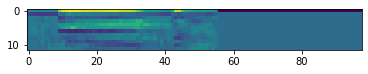

In [31]:
from PIL import Image
import matplotlib.pyplot as plt

np.random.seed(1)
for i, fp in tqdm_notebook(enumerate(male_wav_fpaths), total=len(male_wav_fpaths)):
    _, input = scipy.io.wavfile.read(fp)
    input = pad_input(input, target_len=max_samples)
    mfc = pipeline(input)
    if i == 0:
        plt.imshow(mfc)
    plt.imsave(f'{mfc_dataset_dir}/male_{i}.jpg', mfc)

  0%|          | 0/6000 [00:00<?, ?it/s]

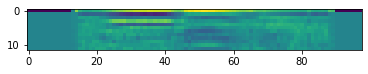

In [32]:
np.random.seed(2)
for i, fp in tqdm_notebook(enumerate(female_wav_fpaths), total=len(female_wav_fpaths)):
    _, input = scipy.io.wavfile.read(fp)  # faster than librosa
    input = pad_input(input, target_len=max_samples)
    mfc = pipeline(input)
    if i == 0:
        plt.imshow(mfc)
    plt.imsave(f'{mfc_dataset_dir}/female_{i}.jpg', mfc)